# Embedding Optimization
We will apply embedding optimization techniques to improve the quality of our embeddings for better recommendation performance. While creating the model we had a lot of options to choose from. Here we will explore some of those options and see how they affect the model performance.

In [65]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
from sentence_transformers import SentenceTransformer, util
from helpers.functs.StudentProfile import StudentProfile 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import platform
import psutil
import torch
import time

## Preparations
Right now we have 5 different student profiles so we can benchmark our models across these profiles. 

In [66]:
# Our mocked student profiles
student1 = StudentProfile(
    current_study= "Kunst & Onderzoek",
    interests=[
        "Tekenen",
        "Animatie",
        "Kunst",
        "Drama",
        "Ik hou ervan om mensen te vermaken. Dit doe ik het liefst door bijvoorbeeld te dansen, te zingen of toneelspelen. In het algemeen vind ik het fijn om creatief bezig te zijn. Ik ben graag onder de mensen."
    ],
    wanted_study_credit_range=(15, 30),
    location_preference=["Den Bosch", "Breda", "Tilburg"],
    learning_goals=["Kritisch denken", "Sociale vaardigheden", "Zelfverzekerdheid", "Ik wil o.a. leren hoe ik betere illustraties kan maken zowel analoog als digitaal."],
    level_preference=["NLQF5", "NLQF6"],
    preferred_language="NL",
    preferred_start_range="any"
)
student2 = StudentProfile(
    current_study= "Informatica",
    interests=[
        "Programmeren",
        "AI",
        "Coderen",
        "Techniek",
        "Software",
        "Ik heb werken met computers en techniek van jongs af aan al interessant gevonden. Kunstmatige intelligentie is nu ook zeker iets dat me interesseert, zeker met de sterke opkomst hiervan. Zo kun je denken aan machine learning, deep learning, etc. Ik wil me vooral bezighouden met software."
    ],
    wanted_study_credit_range=(15, 30),
    location_preference=["Den Bosch", "Breda", "Tilburg"],
    learning_goals=["Kritisch denken", "Technische Vaardigheden", "Eén van de dingen die ik wil leren is het toepassen van mijn kennis in de praktijk"],
    level_preference=["NLQF5", "NLQF6"],
    preferred_language="NL",
    preferred_start_range="any"
)
student3 = StudentProfile(
    current_study= "Psychologie",
    interests=[
        "Mensen",
        "Emoties",
        "Gedrag",
        "Psychologie",
        "Ik wil graag weten waarom mensen bepaalde dingen doen; ik wil mensen hun gedrag kunnen begrijpen. Naast hun gedrag wil ik ook leren over, persoonlijkheden en emoties. Graag wil ik mensen hun welzijn kunnen bevorderen met het gebruik van psychologische kennis."
    ],
    wanted_study_credit_range=(15, 30),
    location_preference=["Den Bosch", "Breda", "Tilburg"],
    learning_goals=["Kritisch denken", "Sociale Vaardigheden", "Ik wil leren hoe ik mensen en hun gedrag beter kan analyseren"],
    level_preference=["NLQF5", "NLQF6"],
    preferred_language="NL",
    preferred_start_range="any"
)

student4 = StudentProfile(
    current_study="Economics",
    interests=[
        "Business",
        "Entrepreneurship",
        "Strategies",
        "Branding",
        "I am a real entrepreneur. I am especially interested in how innovation, strategy, and future developments influence economic growth and organizational success"
    ],
    wanted_study_credit_range=(15, 30),
    location_preference=["Den Bosch", "Breda", "Tilburg"],
    learning_goals=["Forward thinking", "Social skill", "I want to better understand the impact of modern technologies on business models"],
    level_preference=["NLQF5", "NLQF6"],
    preferred_language="NL",
    preferred_start_range="any"
)

student5 = StudentProfile(
    current_study="Verpleegkunde, Mens en Techniek",
    interests=[
        "Zorg",
        "Gezondheid",
        "Medisch",
        "Verpleegkunde",
        "Ik ben erg geïnteresseerd in verpleegkunde en hoop ook later in een ziekenhuis omgeving te kunnen werken. Daarom wil ik ook meer praktische ervaring op doen passend bij mijn studie verpleegkunde met de module die ik kies."
    ],
    wanted_study_credit_range=(15, 30),
    location_preference=["Den Bosch", "Breda", "Tilburg"],
    learning_goals=["Sociale vaardigheden", "Persoonlijke ontwikkeling", "Ik leren hoe ik beter kan anticiperen op bepaalde zorgbehoeften"],
    level_preference=["NLQF5", "NLQF6"],
    preferred_language="NL",
    preferred_start_range="any"
)

students = [student1, student2, student3, student4, student5]

To evaluate the models performance on the datasets we will use the precision@k metric. For each student profile, we will generate recommendations using different embedding models and compute the precision@k by comparing the recommended modules against the known relevant modules for that profile. This will help us identify which embedding model performs best for our recommendation system. 

In [67]:
# Ground-truth relevant modules per student
ground_truth = {
    "student1": [388, 392, 191, 385, 386, 379, 389, 377, 391, 233],
    "student2": [304, 305, 312, 317, 318, 322, 321, 334, 336, 340, 333],
    "student3": [159, 290, 397, 180, 177, 208, 173, 193, 357],
    "student4": [229, 272, 280, 279, 235, 380],
    "student5": [160, 199, 161, 163]
}

We also had a thought: `What if we use different types of preprocessing techniques?` While data cleaning is important, different NLP tasks may benefit from different levels of text preprocessing. For instance, some models might perform better with lemmatized text, while others might benefit from retaining the original word forms. We will experiment with various preprocessing techniques to see how they impact the embedding quality and recommendation performance.

In [68]:
def load_and_prepare(path):
    """Load CSV and turn selected columns into merged clean text."""
    df = pd.read_csv(path)
    cols = ['name', 'description', 'learningoutcomes', 'module_tags']

    text = (
        df[cols]
        .fillna('')
        .astype(str)
        .agg(' '.join, axis=1)
        .str.replace(r'\s+', ' ', regex=True)
        .tolist()
    )
    return df, text, df['id'].tolist()

soft_df, soft_text, soft_ids = load_and_prepare('../Data/Cleaned/cleaned_dataset_soft-NLP.csv')
hard_df, hard_text, hard_ids = load_and_prepare('../Data/Cleaned/cleaned_dataset_hard-NLP.csv')

nlp_options = {
    "soft": (soft_text, soft_ids, soft_df),
    "hard": (hard_text, hard_ids, hard_df),
}

For the model choices, we will experiment with different embedding models. Each of these models has its own strengths and weaknesses, and we will evaluate their performance on the recommendation task. Additionally, we will explore different hyperparameter settings for these models to further optimize their performance. We got these models as a result of our own research on forms and a quick prompt to ChatGPT.

In [69]:
force_cpu = False

# CUDA → NVIDIA GPU
if not force_cpu and torch.cuda.is_available():
  device = "cuda"
# MPS → Apple Silicon GPU
elif not force_cpu and hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
  device = "mps"
# CPU fallback
else:
  device = "cpu"

if device == "cpu":
  core_count = psutil.cpu_count(logical=True)
  torch.set_num_threads(core_count) # PyTorch threading
  cpu_brand = platform.processor().lower()
  
print(f"Using device: {device}")
if device == "cpu":
    print(f"CPU brand detected: {cpu_brand}")
    print(f"Using {core_count} CPU threads for maximum performance")

Using device: cuda


In [70]:
model_options = {
    "model1": SentenceTransformer("all-MiniLM-L6-v2", device=device),
    "model2": SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2", device=device),
    "model3": SentenceTransformer("distiluse-base-multilingual-cased-v2", device=device),
    # "model4": SentenceTransformer("paraphrase-multilingual-mpnet-base-v2", device=device),
    # "model5": SentenceTransformer("multi-qa-mpnet-base-dot-v1", device=device),
}

For the similarity metrics, we will experiment with different distance metrics to measure the similarity between embeddings. Common choices include cosine similarity, Euclidean distance, and Manhattan distance. Each metric may capture different aspects of similarity, and we will evaluate their impact on the recommendation quality.

In [71]:
similarity_metrics = ["cosine", "euclidean", "manhattan"]

## Variations
Here i will make a nice loop to iterate through the different variations of the models, preprocessing techniques, and similarity metrics. For each combination, we will generate recommendations for the student profiles and compute the precision@k metric. This will allow us to evaluate the performance of each configuration and identify the best-performing setup for our recommendation system.

In [72]:
def batch_encode(model, texts, batch_size=32):
    """Encode texts in batches to reduce (GPU) memory usage and increase speed."""
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        emb = model.encode(batch, convert_to_tensor=True, device=device)
        embeddings.append(emb)
    return torch.cat(embeddings)


def compute_similarity(metric, query_vec, module_vecs):
    """Return a similarity score array for a given metric."""
    if metric == "cosine":
        sims = util.cos_sim(query_vec, module_vecs)[0].cpu().numpy()
    elif metric == "euclidean":
        dists = euclidean_distances(
            query_vec.cpu().numpy(),
            module_vecs.cpu().numpy()
        )[0]
        sims = -dists
    elif metric == "manhattan":
        dists = manhattan_distances(
            query_vec.cpu().numpy(),
            module_vecs.cpu().numpy()
        )[0]
        sims = -dists

    return sims

def precision_at_k(top_matches, k, relevant_set):
    """Compute precision@k."""
    top_indices = [idx for idx, _ in top_matches[:k]]
    return sum(1 for idx in top_indices if idx in relevant_set) / k


In [73]:
benchmark_data = []
top_k = 5

# For each student profile
for s_idx, student in enumerate(students, start=1):
    query_text = student.to_text()
    student_name = f"student{s_idx}"

    # For each NLP dataset option
    for nlp_name, (module_texts, module_ids, df_map) in nlp_options.items():

        # filter dataset
        # module_texts, module_ids = pre_filter_modules(df_map, module_texts, module_ids)

        id_to_name = dict(zip(df_map['id'], df_map['name']))

        # For each model choice
        for model_name, model in model_options.items():
            # encode module vectors once per model
            module_vectors = batch_encode(model, module_texts, batch_size=32)
            query_vector = model.encode([query_text], convert_to_tensor=True, device=device)

            # For each similarity metric
            for metric in similarity_metrics:

                start_time = time.time()
                sims = compute_similarity(metric, query_vector, module_vectors)

                top_indices = sims.argsort()[::-1][:top_k]
                top_matches = [(module_ids[i], float(sims[i])) for i in top_indices]

                # readable predictions
                predictions = [
                    {"module_id": mid, "score": score, "name": id_to_name.get(mid, "")}
                    for mid, score in top_matches
                ]

                gt_key = student_name.lower()
                relevant_set = set(ground_truth.get(gt_key, []))
                prec = precision_at_k(top_matches, top_k, relevant_set)

                elapsed = time.time() - start_time

                benchmark_data.append({
                    "student": student_name,
                    "model": model_name,
                    "nlp": nlp_name,
                    "metric": metric,
                    "precision@5": prec,
                    "time_sec": elapsed,
                    "predictions": predictions
                })


I will save the results in a csv file for better retrieval for graphing later.

In [74]:
benchmark_df = pd.DataFrame(benchmark_data)
benchmark_df.to_csv("../Data/Results/benchmark_se_results.csv", index=False)
benchmark_df.head()

,student,model,nlp,metric,precision@5,time_sec,predictions
0,student1,model1,soft,cosine,1.0,0.000000,"[{'module_id': 191, 'score': 0.687917351722717..."
1,student1,model1,soft,euclidean,1.0,0.001544,"[{'module_id': 191, 'score': -0.79004132747650..."
2,student1,model1,soft,manhattan,1.0,0.000000,"[{'module_id': 191, 'score': -12.3472660149349..."
3,student1,model2,soft,cosine,0.8,0.000000,"[{'module_id': 191, 'score': 0.713423728942871..."
4,student1,model2,soft,euclidean,1.0,0.001528,"[{'module_id': 191, 'score': -2.35390472412109..."


In [75]:
# benchmark_df = pd.read_csv("../Data/Results/benchmark_se_results.csv")

## presision@k Evaluation
We will evaluate the performance of each variation using precision@k metric to determine which configuration yields the best results.

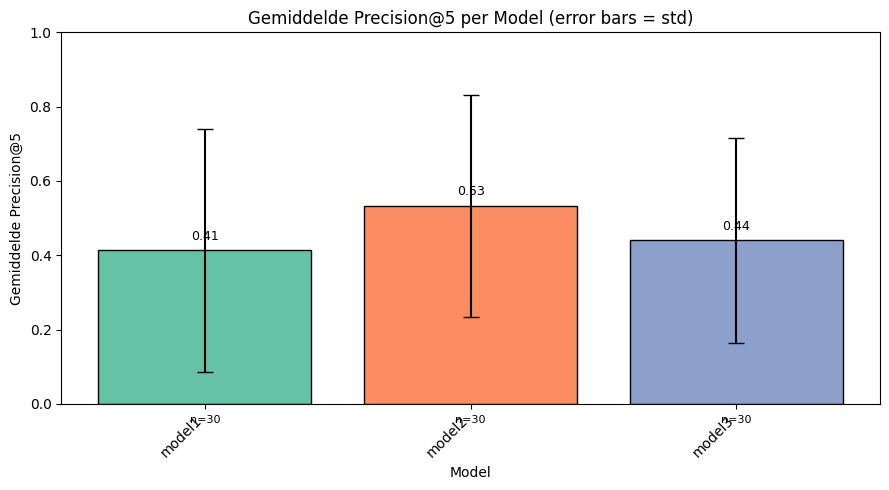

         mean    std  count
model                      
model1  0.413  0.328     30
model2  0.533  0.299     30
model3  0.440  0.275     30


In [76]:
# Aggregate mean, std and count per model
agg = benchmark_df.groupby("model")["precision@5"].agg(["mean", "std", "count"]).reset_index().set_index("model")
means = agg["mean"].fillna(0).values
stds = agg["std"].fillna(0).values
counts = agg["count"].astype(int).values
model_names = agg.index.tolist()

# Plot bar chart with error bars (std) and annotate sample counts
plt.figure(figsize=(9, 5))
palette = sns.color_palette("Set2", n_colors=len(means))
bars = plt.bar(range(len(means)), means, yerr=stds, capsize=6, color=palette, edgecolor="k")

plt.xticks(range(len(means)), model_names, rotation=45, ha="right")
plt.ylim(0, 1)
plt.ylabel("Gemiddelde Precision@5")
plt.xlabel("Model")
plt.title("Gemiddelde Precision@5 per Model (error bars = std)")

# Annotate mean values on top of bars and sample counts below ticks
for i, (b, mean, std, cnt) in enumerate(zip(bars, means, stds, counts)):
  h = b.get_height()
  plt.text(b.get_x() + b.get_width() / 2, h + 0.02, f"{mean:.2f}", ha="center", va="bottom", fontsize=9)

# put counts under the x-ticks (so they align with rotated labels)
for i, cnt in enumerate(counts):
  plt.text(i, -0.03, f"n={cnt}", ha="center", va="top", fontsize=8)

plt.tight_layout()
plt.show()

# Also print the aggregated table for quick inspection
print(agg[["mean", "std", "count"]].round(3))

In [77]:
# # Use benchmark_df to display per-student, per-nlp, per-model precision (and runtime)
# # and also create pivot tables for easier inspection.

# # pivot tables for quick numeric overview
# pivot_prec = benchmark_df.pivot_table(index='student', columns='model', values='precision@5')
# pivot_time = benchmark_df.pivot_table(index='student', columns='model', values='time_sec')

# print("Precision@5 pivot (rows=student, cols=model):\n", pivot_prec.round(3), "\n")
# print("Runtime pivot (seconds):\n", pivot_time.round(3), "\n")

# # readable per-student breakdown using benchmark_df
# for student_name in benchmark_df['student'].unique():
#     print(f"\n===== {student_name} =====")
#     for nlp_type in benchmark_df['nlp'].unique():
#         sub = benchmark_df[(benchmark_df['student'] == student_name) & (benchmark_df['nlp'] == nlp_type)]
#         if sub.empty:
#             continue
#         print(f"\n-- {nlp_type.upper()} NLP --")
#         for _, row in sub.sort_values('model').iterrows():
#             prec = row['precision@5']
#             time_s = row['time_sec']
#             prec_str = f"{prec:.2f}" if pd.notna(prec) else "n/a"
#             time_str = f"{time_s:.3f}s" if pd.notna(time_s) else "n/a"
#             print(f"{row['model']}: Precision@{top_k} = {prec_str} in {time_str}")

### Graph 1: Performance per Model
We will visualize the performance of each model variation using bar plots and scatter plots to compare precision@k.

In [78]:
# # Average Precision per Model & NLP
# # compute average precision grouped by model and NLP type
# avg_precision = benchmark_df.groupby(['model'])['precision@5'].mean().reset_index()

# plt.figure(figsize=(8,5))
# sns.barplot(data=avg_precision, x='model', y='precision@5', palette="Set1")
# plt.title("Average Precision@5 per Model", fontsize=14)
# plt.ylabel("Precision@5", fontsize=12)
# plt.xlabel("Model", fontsize=12)
# plt.ylim(0, 1)
# plt.tight_layout()
# plt.show()

In [79]:
# # Aggregate average metrics per model (all students & NLP types)
# model_perf = benchmark_df.groupby('model').agg({
#     'precision@5': 'mean',
#     'time_sec': 'mean'
# }).reset_index()

# # Bar plot: Precision vs Runtime
# fig, ax1 = plt.subplots(figsize=(8,5))

# sns.barplot(data=model_perf, x='model', y='precision@5', palette="Blues", ax=ax1)
# ax1.set_ylabel("Avg Precision@5", color="blue", fontsize=12)
# ax1.set_ylim(0, 1)
# ax1.set_xlabel("Model", fontsize=12)
# ax1.set_title("Performance per Model: Precision & Runtime", fontsize=14)

# # Add a second y-axis for runtime
# ax2 = ax1.twinx()
# sns.lineplot(data=model_perf, x='model', y='time_sec', marker="o", color="red", ax=ax2)
# ax2.set_ylabel("Avg Runtime (sec)", color="red", fontsize=12)

# # Add value labels on bars for precision
# for i, row in model_perf.iterrows():
#     ax1.text(i, row['precision@5'] + 0.02, f"{row['precision@5']:.2f}", ha='center', color='blue')

# plt.tight_layout()
# plt.show()


In [80]:
# # Average Runtime per Model & NLP
# avg_time = benchmark_df.groupby(['model','nlp'])['time_sec'].mean().reset_index()
# plt.figure(figsize=(8,5))
# sns.barplot(data=avg_time, x='model', y='time_sec', hue='nlp', palette="Set1")
# plt.title("Average Runtime per Model & NLP Type", fontsize=14)
# plt.ylabel("Time (seconds)", fontsize=12)
# plt.xlabel("Model", fontsize=12)
# plt.tight_layout()
# plt.show()

In [81]:
# # Scatter Plot: Precision vs Runtime per Model & NLP
# plt.figure(figsize=(8,6))
# sns.scatterplot(data=benchmark_df, x='time_sec', y='precision@5', hue='model', style='nlp', s=100)
# plt.title("Precision vs Runtime per Model & NLP")
# plt.xlabel("Runtime (sec)")
# plt.ylabel("Precision@5")
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.show()


## Conclusion
After evaluating the different variations of embedding models, NLP preprocessing techniques, and their impact on performance metrics, we will summarize the findings and recommend the optimal configuration for our recommendation system.

### Findings
- Average metrics (all students & NLP types): Model1: precision@5 = 0.42 (≈0.136s), Model2: 0.54 (≈0.133s), Model3: 0.56 (≈0.182s).  
- Model3 yields the best overall accuracy; Model2 is nearly as accurate but consistently faster.  
- Per-student behavior varies: student1 achieves very high precision across models; students 2–3 benefit noticeably from Model2/Model3; students 4–5 show mixed results depending on NLP preprocessing (soft vs hard).  
- Soft vs Hard NLP preprocessing affects recommendations per domain — no single NLP choice is uniformly best across all students.